## Horizontal Photovoltaic Power Prediction for 12 Sites

### Import relevant libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from lightgbm import LGBMRegressor

from skopt import BayesSearchCV

### Load dataset

In [6]:
df = pd.read_csv('Pasion et al dataset.csv')

### Explore the data

##### Identify available columns in the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       21045 non-null  object 
 1   Date           21045 non-null  int64  
 2   Time           21045 non-null  int64  
 3   Latitude       21045 non-null  float64
 4   Longitude      21045 non-null  float64
 5   Altitude       21045 non-null  int64  
 6   YRMODAHRMI     21045 non-null  float64
 7   Month          21045 non-null  int64  
 8   Hour           21045 non-null  int64  
 9   Season         21045 non-null  object 
 10  Humidity       21045 non-null  float64
 11  AmbientTemp    21045 non-null  float64
 12  PolyPwr        21045 non-null  float64
 13  Wind.Speed     21045 non-null  int64  
 14  Visibility     21045 non-null  float64
 15  Pressure       21045 non-null  float64
 16  Cloud.Ceiling  21045 non-null  int64  
dtypes: float64(8), int64(7), object(2)
memory usage: 2

In [4]:
df.head()

,Location,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9


##### Calculate summary statistics of numerical columns

In [5]:
df.describe()

,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
count,2.104500e+04,21045.000000,21045.000000,21045.000000,21045.000000,2.104500e+04,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000
mean,2.017720e+07,1267.483725,38.213823,-108.593678,798.843668,2.017718e+11,6.565883,12.627845,37.121941,29.285117,12.978583,10.318318,9.700071,925.944747,515.966785
std,4.579585e+03,167.602767,6.323761,16.364130,770.681794,4.579846e+07,2.983958,1.672952,23.823011,12.366820,7.123255,6.385030,1.351949,85.215659,301.903379
min,2.017052e+07,1000.000000,20.890000,-156.440000,1.000000,2.017050e+11,1.000000,10.000000,0.000000,-19.981770,0.257330,0.000000,0.000000,781.700000,0.000000
25%,2.017111e+07,1100.000000,38.160000,-117.260000,2.000000,2.017110e+11,4.000000,11.000000,17.529300,21.915280,6.404570,6.000000,10.000000,845.500000,140.000000
50%,2.018032e+07,1300.000000,38.950000,-111.180000,458.000000,2.018030e+11,7.000000,13.000000,33.123780,30.289150,13.798700,9.000000,10.000000,961.100000,722.000000
75%,2.018062e+07,1400.000000,41.150000,-104.710000,1370.000000,2.018060e+11,9.000000,14.000000,52.593990,37.474670,18.863650,14.000000,10.000000,1008.900000,722.000000
max,2.018100e+07,1545.000000,47.520000,-80.110000,1947.000000,2.018100e+11,12.000000,15.000000,99.987790,65.738370,34.285020,49.000000,10.000000,1029.500000,722.000000


##### Visualize data distribution

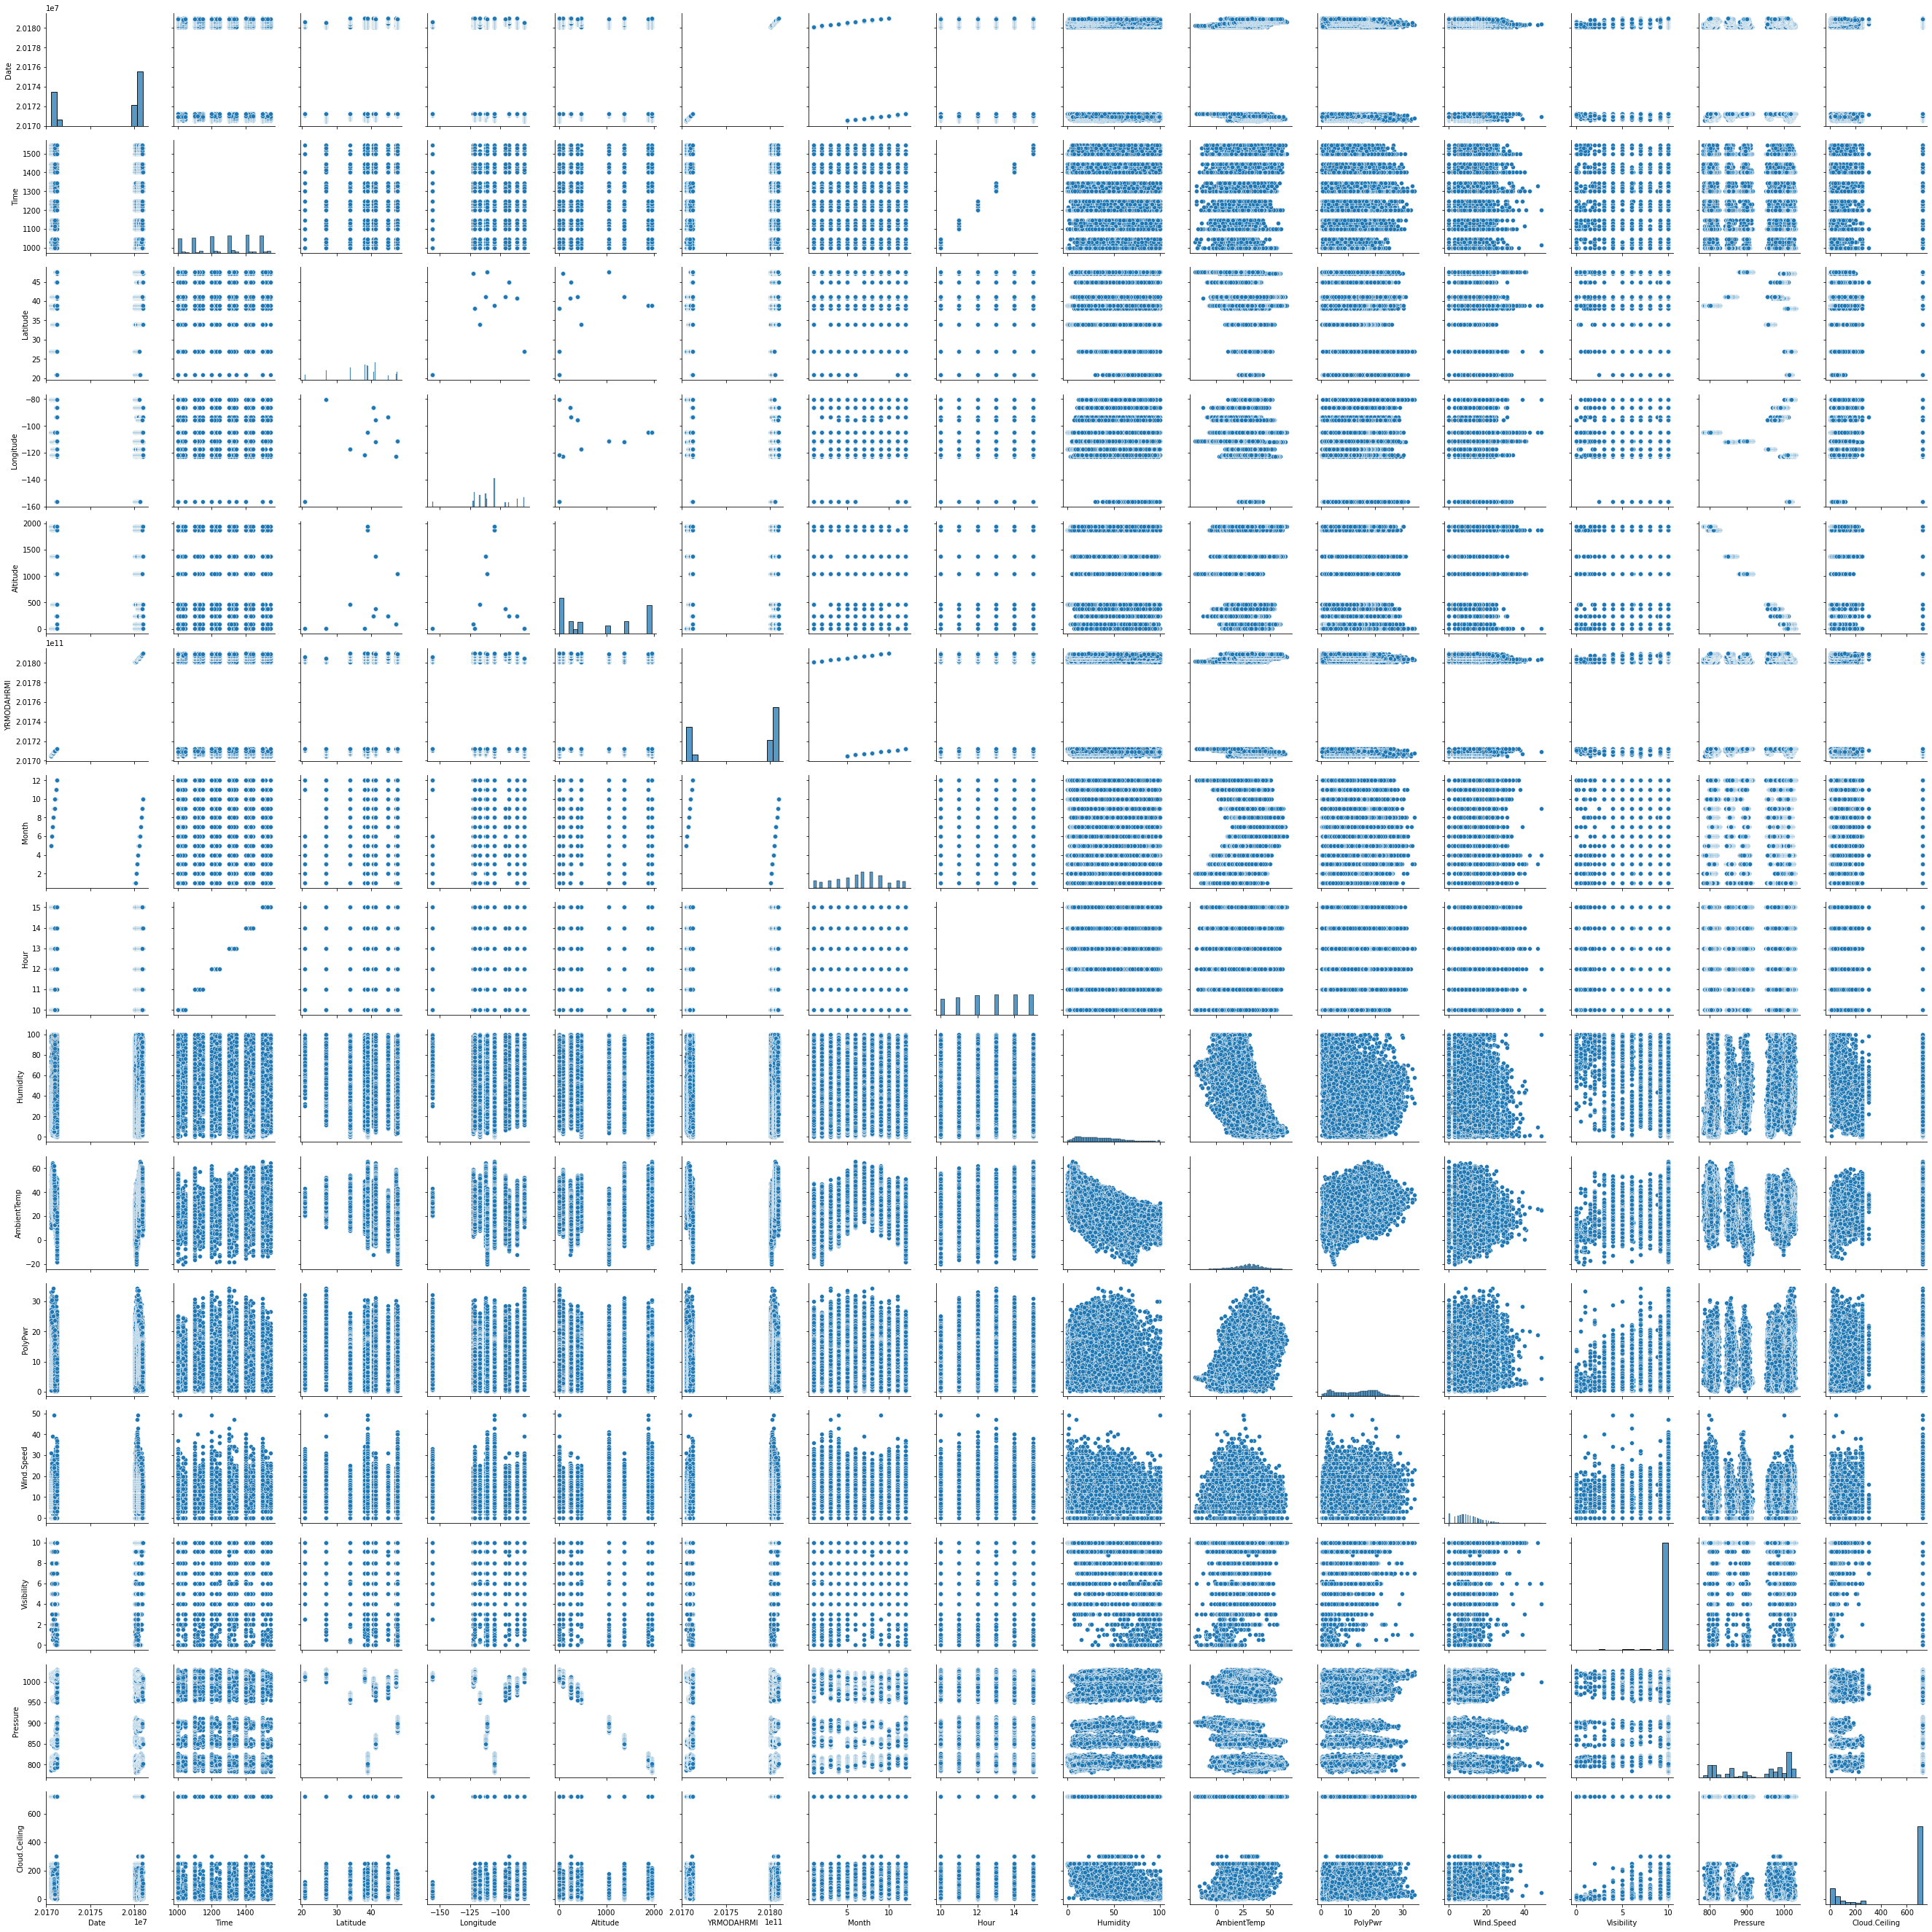

In [6]:
sns.pairplot(df);

##### Correlation analysis

In [50]:
df_corr = df[['Location', 'Time', 'Latitude', 'Longitude', 'Altitude',
              'YRMODAHRMI', 'Month', 'Hour', 'Season', 'Humidity', 'AmbientTemp',
              'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling', 'PolyPwr']].corr()

In [60]:
mask = np.triu(np.ones_like(df_corr, dtype=bool))

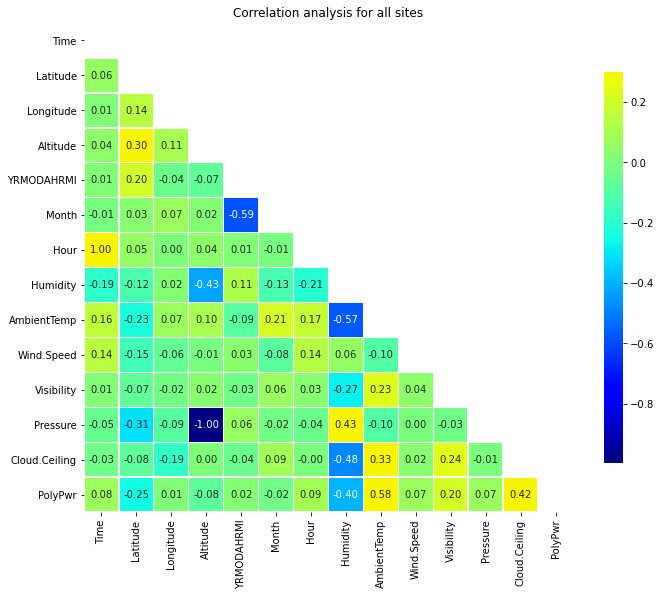

In [57]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_corr, mask=mask, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis for all sites');

### Summary of data Explorartion

<font size="3"> 1. The correlation between Ambient temperature, humidity and power improved when using site level data rather than fleet level data.<br/>
<font size="3"> 2. Also, some input features have their correlation sign with target change for individual sites compared with total sites data (e.g windspeed). <br/>
<font size="3"> 3. Hence, it may be necessary to build machine learning models per site to get the best out of the models. It might also be worth trying to encode the site-specific features like site location.<br/>
<font size="3"> 4. Altitude and pressure are perfectly correlated however, altitude does not change for a particular site and cannot be used for site-level modeling.

### Data Preprocessing

##### Check for missing values

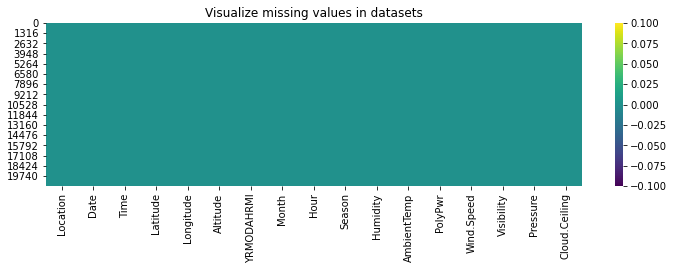

In [49]:
plt.figure(figsize=(12, 3))
sns.heatmap(df.isnull(), cmap='viridis');
plt.title('Visualize missing values in datasets');

##### Feature Engineering

In [7]:
# Encode location data
df_with_location_en = pd.get_dummies(df, columns=['Location'], drop_first=True)

In [8]:
# Encode season data
df_with_loc_season_en = pd.get_dummies(df_with_location_en, columns=['Season'], drop_first=True)

In [9]:
min_hour_of_interest = 10
max_hour_of_interest = 15

In [10]:
df_with_loc_season_en['delta_hr']= df_with_loc_season_en.Hour - min_hour_of_interest

In [11]:
# Create Cyclic date features
df_with_loc_season_en['sine_mon']= np.sin((df_with_loc_season_en.Month - 1)*np.pi/11)
df_with_loc_season_en['cos_mon']= np.cos((df_with_loc_season_en.Month - 1)*np.pi/11)
df_with_loc_season_en['sine_hr']= np.sin((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))
df_with_loc_season_en['cos_hr']= np.cos((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))

In [12]:
mask2 = np.triu(np.ones_like(df_with_loc_season_en.corr(), dtype=bool))

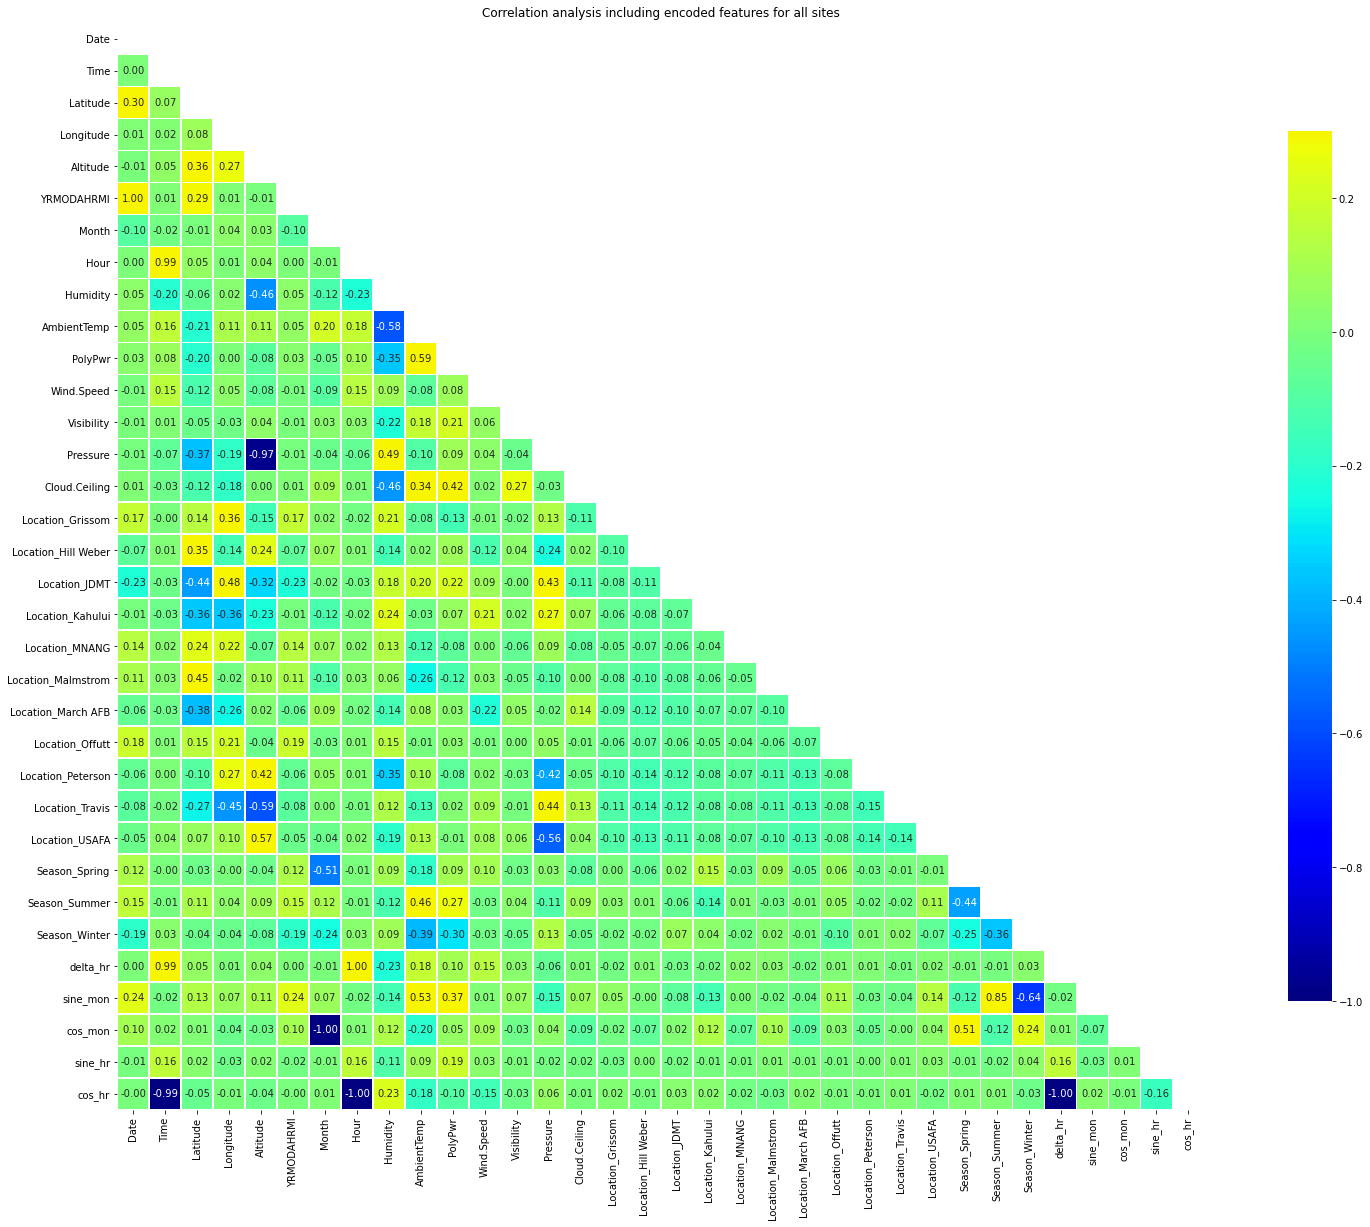

In [13]:
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(df_with_loc_season_en.corr(method='spearman'), mask=mask2, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis including encoded features for all sites');

### Modeling

##### Feature Selection

In [12]:
selected_columns = ['Latitude', 'Humidity', 'AmbientTemp', 'PolyPwr', 'Wind.Speed',
                     'Visibility', 'Pressure', 'Cloud.Ceiling', 'Location_Grissom',
                     'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                     'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                     'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                     'Location_USAFA','Season_Spring', 'Season_Summer', 'Season_Winter',
                     'sine_mon', 'cos_mon', 'sine_hr', 'cos_hr']

In [13]:
df_processed = df_with_loc_season_en[selected_columns].reset_index(drop=True)

In [14]:
target_label = 'PolyPwr'

In [15]:
input_feat = list(set(selected_columns).difference(set([target_label])))

##### Summary of feature selection

<font size="3"> 1. Altitude is dropped because it has a high correlation with Pressure but does not change for a given location while presesure is more dynamic. <br/>
<font size="3"> 2. Longitude is dropped because it has zero correlation with the target variable. <br/>
<font size="3"> 3. Time, Hour, Month and Date are dropped because they have strong correlations with the engineered cyclic features but low correlation with the target variable. 

##### Extract test set from all data

In [16]:
df_X = df_processed[input_feat].reset_index(drop=True)

In [17]:
df_y = df_processed[target_label]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

##### Perform Cross-validation on training data for hyper-parameter tuning

In [19]:
# Create list of each hyper-param to tune
n_estimators_list = [int(50*x) for x in range(2, 30)]

learning_rate_list = [round(x/500, 4) for x in range(2, 25)]

max_depth_list = [int(x) for x in range(3, 13)]
max_depth_list.append(-1)

n_leaves_list = [int(50*x) for x in range(2, 30)]

feature_fraction_list = [x/10 for x in range(1, 10)]

objective_list = ['rmse', 'mae', 'mape']

In [126]:
# Structure model hyper-params as a dictionary
lgbm_grid = {'num_leaves':n_leaves_list,
             'max_depth':max_depth_list,
             'learning_rate':learning_rate_list,
             'n_estimators':n_estimators_list,
             'feature_fraction':feature_fraction_list,
             'objective':objective_list}

In [127]:
# Create base LGBM model
lgbm_base = LGBMRegressor()

##### Random search CV

In [65]:
# Create random search for LGBM model
lgbm_random = RandomizedSearchCV(estimator=lgbm_base, param_distributions=lgbm_grid, 
                                 n_iter=1000, cv=4, verbose=2, random_state=42, 
                                 n_jobs=-1)

In [66]:
%%time
# Fit the random search LGBM model
lgbm_random.fit(X_train, y_train)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Wall time: 1h 19min 37s


RandomizedSearchCV(cv=4, estimator=LGBMRegressor(), n_iter=1000, n_jobs=-1,
                   param_distributions={'feature_fraction': [0.1, 0.2, 0.3, 0.4,
                                                             0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.004, 0.006, 0.008,
                                                          0.01, 0.012, 0.014,
                                                          0.016, 0.018, 0.02,
                                                          0.022, 0.024, 0.026,
                                                          0.028, 0.03, 0.032,
                                                          0.034, 0.036, 0.038,
                                                          0.04, 0.042, 0.044,
                                                          0.046, 0.048],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9

In [67]:
# Get optimal hyper-params
lgbm_random.best_params_

{'objective': 'rmse',
 'num_leaves': 1400,
 'n_estimators': 900,
 'max_depth': 11,
 'learning_rate': 0.008,
 'feature_fraction': 0.6}

In [140]:
# Get score of best model during hyper-param tuning
lgbm_random.best_score_

0.6699517136501209

In [152]:
mean_score = lgbm_random.cv_results_['mean_test_score']
std_score = lgbm_random.cv_results_['std_test_score']
params = lgbm_random.cv_results_['params']

In [153]:
cv_score_df = pd.DataFrame(params)
cv_score_df['mean_score'] = mean_score
cv_score_df['std_score'] = std_score

In [154]:
# cv_score_df.to_csv('lgbm_1000it_12_29_2021_case3.csv', index=False)

In [155]:
# all_results_cv_df = pd.DataFrame(lgbm_random.cv_results_)

In [156]:
# all_results_cv_df.to_csv('lgbm_1000it_12_29_2021_case3_all_results.csv', index=False)

##### Train model using optimal hyper-parameters from above

In [43]:
# Random
lgbm_model = LGBMRegressor(objective='rmse', num_leaves=900, n_estimators=1400, max_depth=11, learning_rate=0.008, feature_fraction=0.6, random_state=42)

In [44]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


LGBMRegressor(feature_fraction=0.6, learning_rate=0.008, max_depth=11,
              n_estimators=1400, num_leaves=900, objective='rmse',
              random_state=42)

##### Make model inferences on test set

In [45]:
y_pred = lgbm_model.predict(X_test)

##### Evaluate model performance on test set

In [46]:
# Explained variance
explained_variance_score(y_test.ravel(), y_pred)

0.6765334429343526

In [47]:
# R2 score
r2_score(y_test.ravel(), y_pred)

0.6765290465149298

In [48]:
# Mean absolute error
mean_absolute_error(y_test.ravel(), y_pred)

2.723043306359508

In [49]:
# Root mean square error
np.sqrt(mean_squared_error(y_test.ravel(), y_pred))

4.053700606764332

In [50]:
mean_absolute_percentage_error(y_test.ravel(), y_pred)*100

50.05764542637969

##### Prediction on full dataset as in reference paper

In [51]:
y_all_pred = lgbm_model.predict(df_X.values)

In [52]:
r2_score(df_y.values, y_all_pred)

0.8181589886497151

##### Feature importance

In [57]:
# Calculate scaled feature importance as a percentage
feat_imp_score = (lgbm_model.feature_importances_/max(lgbm_model.feature_importances_)*100).tolist()

In [58]:
feature_ranking_with_score = dict(sorted(zip(feat_imp_score, input_feat), reverse=True))
feature_ranking_with_score

{100.0: 'Humidity',
 97.85483459477847: 'Pressure',
 95.83510502593758: 'AmbientTemp',
 63.45352495960541: 'Wind.Speed',
 37.9666638319585: 'Cloud.Ceiling',
 33.406327068628286: 'sine_mon',
 30.317203843864277: 'cos_hr',
 25.31465260651416: 'Latitude',
 25.02976443575134: 'cos_mon',
 22.240411599625816: 'sine_hr',
 5.463899991495875: 'Season_Spring',
 5.36822859086657: 'Visibility',
 4.755931626839017: 'Season_Summer',
 4.020324857555915: 'Location_Hill Weber',
 3.6950420954162766: 'Location_USAFA',
 3.4314142359044135: 'Location_Peterson',
 3.410153924653457: 'Location_Grissom',
 2.6554128752444934: 'Location_JDMT',
 2.551237350114806: 'Location_Travis',
 2.4045412024832045: 'Location_MNANG',
 2.153669529721915: 'Location_Kahului',
 1.992091164214644: 'Location_Offutt',
 1.8815375457096692: 'Season_Winter',
 1.8092524874564162: 'Location_March AFB',
 1.1756952121779063: 'Location_Malmstrom'}

In [55]:
feat_ranking_list = list(feature_ranking_with_score.values())

In [56]:
np.array(feat_ranking_list)

array(['Humidity', 'Pressure', 'AmbientTemp', 'Wind.Speed',
       'Cloud.Ceiling', 'sine_mon', 'cos_hr', 'Latitude', 'cos_mon',
       'sine_hr', 'Season_Spring', 'Visibility', 'Season_Summer',
       'Location_Hill Weber', 'Location_USAFA', 'Location_Peterson',
       'Location_Grissom', 'Location_JDMT', 'Location_Travis',
       'Location_MNANG', 'Location_Kahului', 'Location_Offutt',
       'Season_Winter', 'Location_March AFB', 'Location_Malmstrom'],
      dtype='<U19')